In [3]:
import numpy as np
import matplotlib.pyplot as plt
from iterative_ensemble_smoother.experimental import DistanceESMDA
from iterative_ensemble_smoother.esmda import ESMDA

# 1D Test

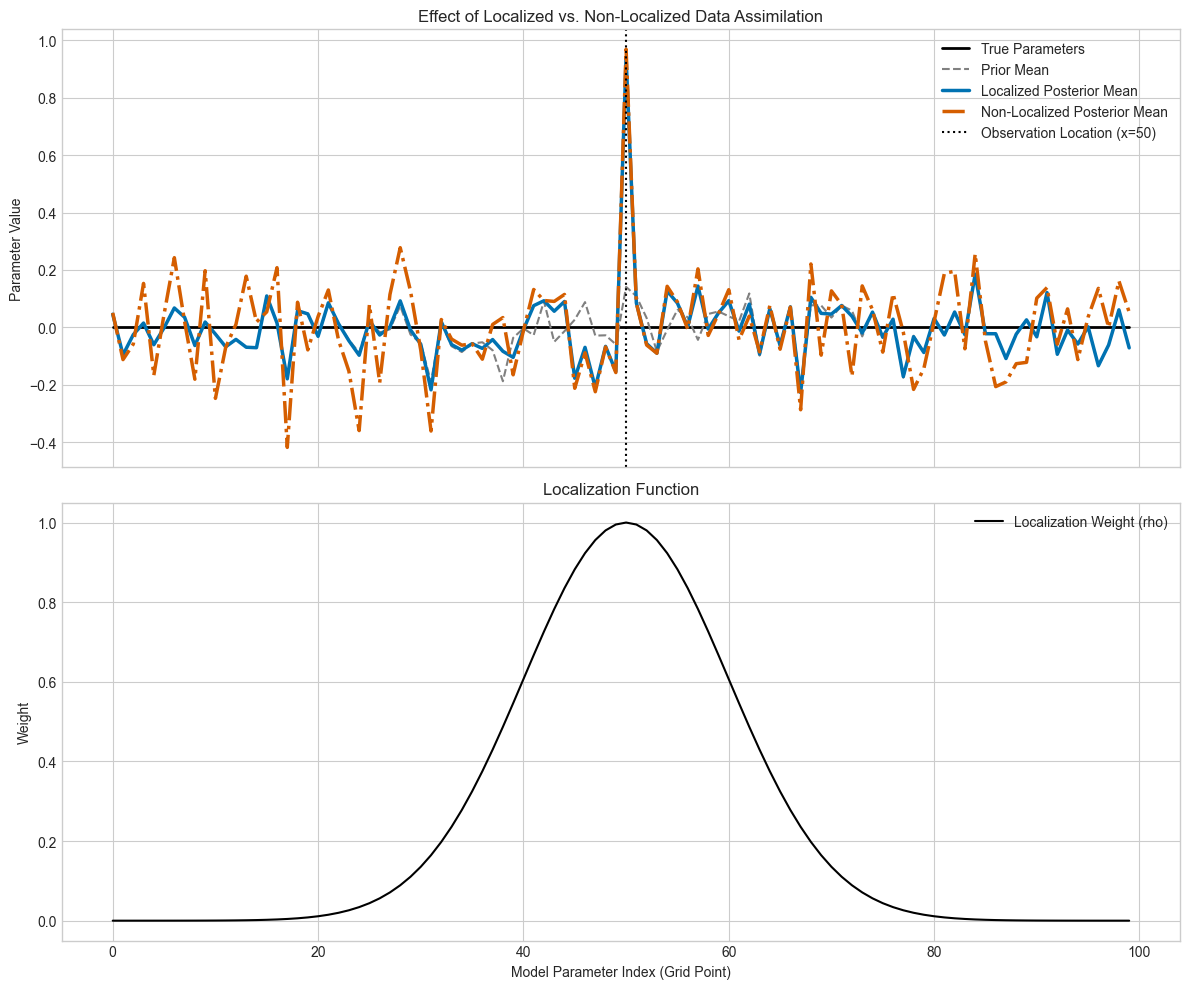

In [4]:
# System properties
N_m = 100  # Number of model parameters (grid points)
N_e = 50   # Ensemble size
j_obs = 50 # Index of the single observation
N_d = 1    # Number of observations

# Assimilation properties
alpha_i = 1 # TODO: Implement multiple iterations
obs_error_var = 0.01 # Variance of observation error
SEED = 42

# Define the "true" model parameters
true_parameters = np.zeros(N_m)

# Define the "true" observation vector (1D)
true_observations = np.array([1.0])

# Observation error covariance `C_D`. Since N_d=1, it's a 1-element vector.
C_D = np.array([obs_error_var])

# --- 2. Generate Initial Ensemble and Predictions ---

# Create initial ensemble of parameters `X` (prior)
# Shape: (N_m, N_e)
rng = np.random.default_rng(SEED)
X_initial = rng.normal(loc=0.0, scale=0.5, size=(N_m, N_e))

# Predict observations `Y` using the identity model `g(x) = x`
# We only observe the state at `j_obs`.
# Shape: (N_d, N_e) -> (1, 50)
Y = X_initial[[j_obs], :]


# --- 3. Construct Localization, Covariance, and Smoother ---

# Localization matrix `rho`
# Shape: (N_m, N_d) -> (100, 1)
localization_radius = 10.0
model_grid = np.arange(N_m)
distances = np.abs(model_grid - j_obs)
# Using a simple Gaussian decay for rho
rho = np.exp(-0.5 * (distances / localization_radius)**2).reshape(-1, 1)

smoother = DistanceESMDA(
    covariance=C_D,
    observations=true_observations,
    alpha=1,
    seed=SEED
)
smoother_ESMDA = ESMDA(
    covariance=C_D,
    observations=true_observations,
    alpha=1,
    seed=SEED)

D = smoother.perturb_observations(
    ensemble_size=N_e, alpha=alpha_i
)

# --- 4. Run Assimilation and Analyze ---

# Run the assimilation
X_posterior = smoother.assimilate(X=X_initial, Y=Y, rho=rho)
X_posterior_ESMDA = smoother_ESMDA.assimilate(X=X_initial, Y=Y)

# Calculate the mean of the prior and posterior ensembles
prior_mean = np.mean(X_initial, axis=1)
posterior_mean = np.mean(X_posterior, axis=1)
posterior_mean_ESMDA = np.mean(X_posterior_ESMDA, axis=1)

# --- 5. Plot the Results ---

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Ensemble means
# Use a colorblind-safe palette and distinct line styles
# From Paul Tol's color schemes: https://personal.sron.nl/~pault/
color_localized = '#0072B2'  # Blue
color_non_localized = '#D55E00' # Orange

ax1.plot(model_grid, true_parameters, color='black', linestyle='-', linewidth=2, label='True Parameters')
ax1.plot(model_grid, prior_mean, color='gray', linestyle='--', linewidth=1.5, label='Prior Mean')
ax1.plot(model_grid, posterior_mean, color=color_localized, linestyle='-', linewidth=2.5, label='Localized Posterior Mean')
ax1.plot(model_grid, posterior_mean_ESMDA, color=color_non_localized, linestyle='-.', linewidth=2.5, label='Non-Localized Posterior Mean')
ax1.axvline(j_obs, color='black', linestyle=':', linewidth=1.5, label=f'Observation Location (x={j_obs})')

ax1.set_ylabel('Parameter Value')
ax1.set_title('Effect of Localized vs. Non-Localized Data Assimilation')
ax1.legend()
ax1.grid(True)

# Plot 2: Localization weights
ax2.plot(model_grid, rho, color='black', label='Localization Weight (rho)')
ax2.set_xlabel('Model Parameter Index (Grid Point)')
ax2.set_ylabel('Weight')
ax2.set_title('Localization Function')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# What to expect:
# The prior mean (gray dashed line) should be a noisy line centered around 0.
#
# The Localized Posterior Mean (red solid line) should be pulled from approx. 0 towards the
# observation value of 1.0. This update should be strong at the observation location (x=50)
# and decay smoothly to zero away from it, following the shape of the localization function.
#
# The Non-Localized Posterior Mean (green dash-dot line) will show updates across the ENTIRE
# domain, not just near the observation. This is because a small ensemble size creates spurious
# correlations between the observation and distant, unrelated parameters.
#
# Consequently, the non-localized update will look noisy and physically unrealistic across the
# domain. This demonstrates why localization is essential to generate plausible reservoir models,
# as applying updates without it can lead to results that differ significantly from the prior models.

# 2D Test

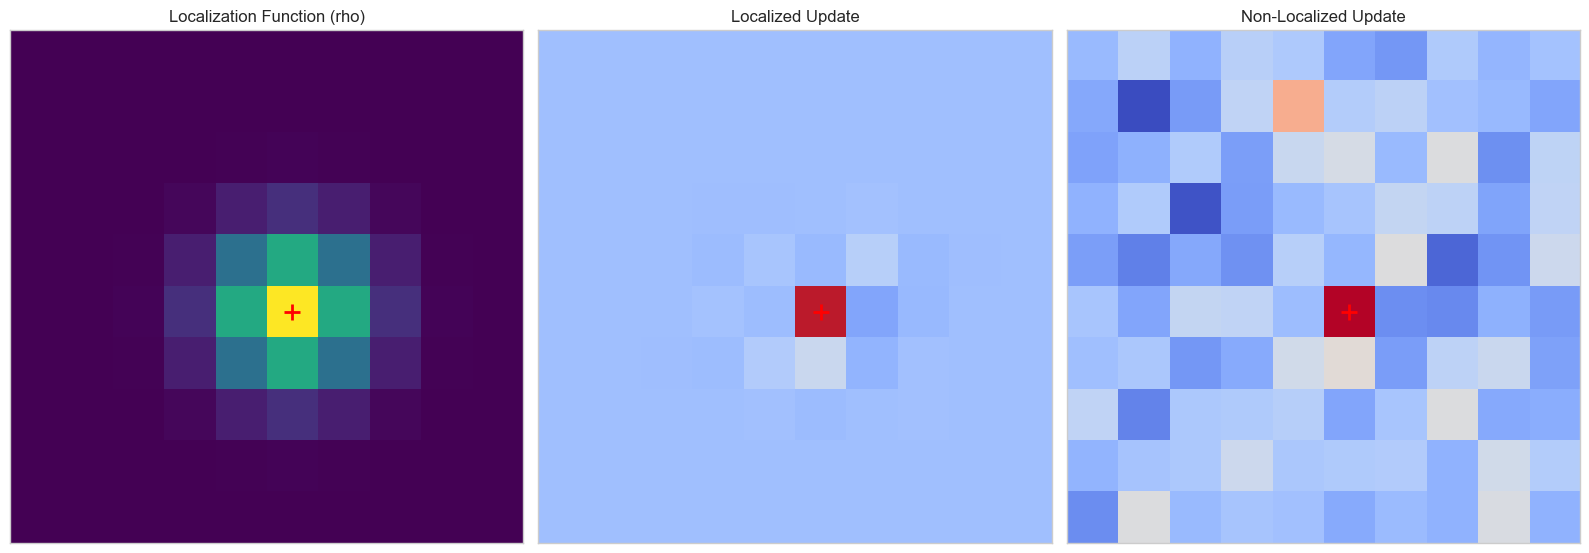

In [30]:
Nx, Ny = 10, 10
N_m = Nx * Ny
N_e = 50
x_obs, y_obs = 5, 5

seed = 42

alpha_i = 1
obs_error_var = 0.01

true_parameters = np.zeros(N_m)
true_observations = np.array([1.0])
C_D = np.array([obs_error_var])

# --- Generate Initial Ensemble and Predictions ---
rng = np.random.default_rng(seed)
X_prior = rng.normal(loc=0.0, scale=0.5, size=(N_m, N_e))

# Convert the 2D observation index to a flat 1D index for slicing
flat_obs_index = y_obs * Nx + x_obs
Y = X_prior[[flat_obs_index], :]

# --- Construct 2D Localization `rho` ---
localization_radius = 1

# Create a 2D coordinate grid
xx, yy = np.meshgrid(np.arange(Nx), np.arange(Ny))
# Calculate 2D Euclidean distance from every point to the observation
distances_2d = np.sqrt((xx - x_obs)**2 + (yy - y_obs)**2)
# Flatten the 2D distance map to a 1D vector to match the parameter vector
distances = distances_2d.flatten()

rho = np.exp(-0.5 * (distances / localization_radius) ** 2).reshape(-1, 1)

# --- Run Assimilations ---
esmda_distance = DistanceESMDA(
    covariance=C_D, observations=true_observations, alpha=alpha_i, seed=rng
)
X_posterior = esmda_distance.assimilate(X=X_prior, Y=Y, rho=rho)

esmda = ESMDA(
    covariance=C_D, observations=true_observations, alpha=alpha_i, seed=rng
)
X_posterior_global = esmda.assimilate(X=X_prior, Y=Y)

# --- Reshape Data for Plotting ---
# Reshape the 1D vectors back into 2D grids for visualization
prior_mean = np.mean(X_prior, axis=1)
prior_mean_2d = prior_mean.reshape((Ny, Nx))
posterior_mean = np.mean(X_posterior, axis=1)
posterior_mean_2d = posterior_mean.reshape((Ny, Nx))

posterior_mean_global = np.mean(X_posterior_global, axis=1)
posterior_mean_global_2d = posterior_mean_global.reshape((Ny, Nx))
rho_2d = rho.reshape((Ny, Nx))

# It's often more insightful to visualize the UPDATE (posterior - prior)
update_localized_2d = posterior_mean_2d - prior_mean_2d
update_global_2d = posterior_mean_global_2d - prior_mean_2d

# --- Create the Plots ---
# Use a 2x3 grid to show the most important comparisons
fig, axes = plt.subplots(1, 3, figsize=(16, 10))

# Find the min/max across both update fields for a fair comparison
update_min = min(update_localized_2d.min(), update_global_2d.min())
update_max = max(update_localized_2d.max(), update_global_2d.max())

# Localization Function (rho)
im = axes[0].imshow(rho_2d, cmap='viridis')
axes[0].set_title('Localization Function (rho)')

# Localized Update
im = axes[1].imshow(update_localized_2d, cmap='coolwarm', vmin=update_min, vmax=update_max)
axes[1].set_title('Localized Update')

# Non-Localized Update
im = axes[2].imshow(update_global_2d, cmap='coolwarm', vmin=update_min, vmax=update_max)
axes[2].set_title('Non-Localized Update')

# Mark the observation location on all plots and hide ticks
for ax in axes.flat:
    ax.plot(x_obs, y_obs, 'r+', markersize=12, markeredgewidth=2) # Red cross
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])

# 3D case

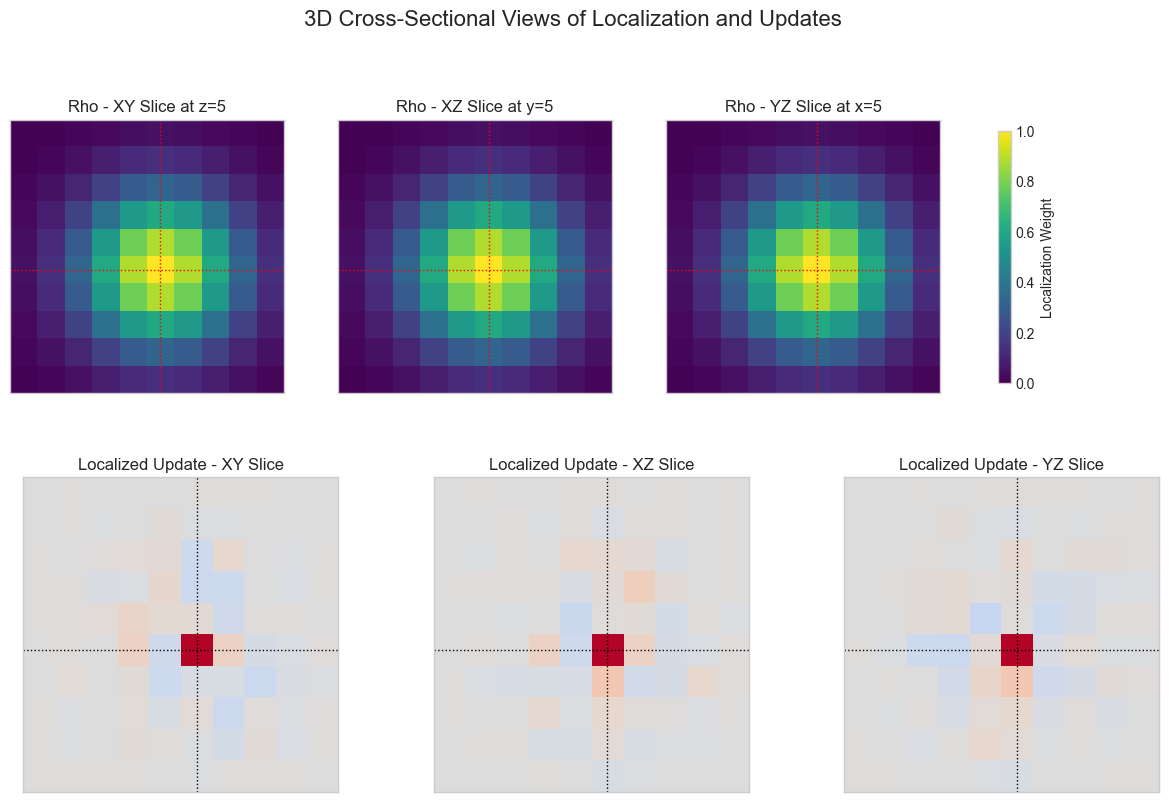

In [33]:
Nx, Ny, Nz = 10, 10, 10
N_m = Nx * Ny * Nz
N_e = 50
x_obs, y_obs, z_obs = 5, 5, 5

seed = 42
alpha_i = 1
obs_error_var = 0.01

true_parameters = np.zeros(N_m)
true_observations = np.array([1.0])
C_D = np.array([obs_error_var])

# --- Generate Initial Ensemble and Predictions ---
rng = np.random.default_rng(seed)
X_prior = rng.normal(loc=0.0, scale=0.5, size=(N_m, N_e))

# Convert the 3D observation index to a flat 1D index for slicing
flat_obs_index = (z_obs * Nx * Ny) + (y_obs * Nx) + x_obs
Y = X_prior[[flat_obs_index], :]

# --- Construct 3D Localization `rho` ---
localization_radius = 2.0

# Create 3D coordinate grids
zz, yy, xx = np.meshgrid(np.arange(Nz), np.arange(Ny), np.arange(Nx), indexing='ij')
# Calculate 3D Euclidean distance from every point to the observation
distances_3d = np.sqrt((xx - x_obs)**2 + (yy - y_obs)**2 + (zz - z_obs)**2)
distances = distances_3d.flatten()

rho = np.exp(-0.5 * (distances / localization_radius) ** 2).reshape(-1, 1)

# --- Run Assimilations ---
# This part remains the same as the assimilation logic is dimension-agnostic
esmda_distance = DistanceESMDA(
    covariance=C_D, observations=true_observations, alpha=alpha_i, seed=rng
)
X_posterior = esmda_distance.assimilate(X=X_prior, Y=Y, rho=rho)

esmda = ESMDA(
    covariance=C_D, observations=true_observations, alpha=alpha_i, seed=rng
)
X_posterior_global = esmda.assimilate(X=X_prior, Y=Y)

# --- Reshape Data and Prepare for 3D Visualization ---
prior_mean = np.mean(X_prior, axis=1)
posterior_mean = np.mean(X_posterior, axis=1)

# Reshape the 1D vectors into 3D volumes
rho_3d = rho.reshape((Nz, Ny, Nx))
update_localized_3d = (posterior_mean - prior_mean).reshape((Nz, Ny, Nx))
update_global_3d = (np.mean(X_posterior_global, axis=1) - prior_mean).reshape((Nz, Ny, Nx))

# --- Create 3D Cross-Sectional Plots ---
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
fig.suptitle('3D Cross-Sectional Views of Localization and Updates', fontsize=16)

# --- Row 1: Slices of the Localization Function (rho) ---
im_rho = axes[0, 0].imshow(rho_3d[z_obs, :, :], cmap='viridis', vmin=0, vmax=1)
axes[0, 0].set_title(f'Rho - XY Slice at z={z_obs}')

axes[0, 1].imshow(rho_3d[:, y_obs, :], cmap='viridis', vmin=0, vmax=1)
axes[0, 1].set_title(f'Rho - XZ Slice at y={y_obs}')

axes[0, 2].imshow(rho_3d[:, :, x_obs], cmap='viridis', vmin=0, vmax=1)
axes[0, 2].set_title(f'Rho - YZ Slice at x={x_obs}')

fig.colorbar(im_rho, ax=axes[0, :], location='right', shrink=0.8, label='Localization Weight')

# --- Slices of the Update Fields ---
# Find a single, symmetric color scale for both update plots
update_max_abs = np.max([np.abs(update_localized_3d), np.abs(update_global_3d)])
vmin_update, vmax_update = -update_max_abs, update_max_abs

# Localized Update
im_update = axes[1, 0].imshow(update_localized_3d[z_obs, :, :], cmap='coolwarm', vmin=vmin_update, vmax=vmax_update)
axes[1, 0].set_title(f'Localized Update - XY Slice')

axes[1, 1].imshow(update_localized_3d[:, y_obs, :], cmap='coolwarm', vmin=vmin_update, vmax=vmax_update)
axes[1, 1].set_title(f'Localized Update - XZ Slice')

axes[1, 2].imshow(update_localized_3d[:, :, x_obs], cmap='coolwarm', vmin=vmin_update, vmax=vmax_update)
axes[1, 2].set_title(f'Localized Update - YZ Slice')

# --- Add Annotations to All Plots ---
# Add crosshairs to pinpoint the observation location in each slice
axes[0, 0].axhline(y_obs, color='r', linestyle=':', lw=1); axes[0, 0].axvline(x_obs, color='r', linestyle=':', lw=1)
axes[0, 1].axhline(z_obs, color='r', linestyle=':', lw=1); axes[0, 1].axvline(x_obs, color='r', linestyle=':', lw=1)
axes[0, 2].axhline(z_obs, color='r', linestyle=':', lw=1); axes[0, 2].axvline(y_obs, color='r', linestyle=':', lw=1)

axes[1, 0].axhline(y_obs, color='k', linestyle=':', lw=1); axes[1, 0].axvline(x_obs, color='k', linestyle=':', lw=1)
axes[1, 1].axhline(z_obs, color='k', linestyle=':', lw=1); axes[1, 1].axvline(x_obs, color='k', linestyle=':', lw=1)
axes[1, 2].axhline(z_obs, color='k', linestyle=':', lw=1); axes[1, 2].axvline(y_obs, color='k', linestyle=':', lw=1)

# Hide axis ticks for a cleaner look
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()